# TNEG Geospatial Visualizations

This notebook contains a base map with county-level breakdown for the state of TN.  

The following dataframes have been joined to the map:  
* ``earthquakes`` Deadly earthquakes since 1900 (from Wikipedia)
* ``usgs`` Earthquakes in and around TN since 1900 (from the USGS API)
* ``TN_demo`` TN county-level demographic information including total population, % of children (under 18), % of people living in rural or isolated settings, % of people of color, % of people with disabilities, and % of senior citizens (from the TN Arts Commission, derived from the 2010 US census)
* ``TN_housing_units_by_county`` TN county-level aggregates of total population and number of housing units (from the 2010 census)
* ``acs_data``

In [1]:
# import statements
import pandas as pd
import numpy as np
import requests
import ipywidgets as widgets
#from bs4 import BeautifulSoup as bs
from IPython.core.display import HTML
#import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab as plt
import json
from bokeh.io import output_file, show, output_notebook, export_png
from bokeh.models import ColumnDataSource, GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.models.widgets import DataTable
from bokeh.plotting import figure
from bokeh.palettes import brewer
import panel as pn
import panel.widgets as pnw
#import seaborn as sns
from io import StringIO
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from cartopy.io import shapereader
%matplotlib inline
# import io
# import scipy.stats as stats
# import statsmodels.api as sm

In [2]:
# display settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Create a base map for the state of TN, broken down by county.

In [3]:
# Create a folium map, but probably not the best idea to subsequently join all of the other data
# tn_map = folium.Map(location=[36,-86], zoom_start = 7)
# tn_map

In [4]:
# Create a base map by importing the base shape file for TN census map
# Annoyingly, this is broken down by census division, not by county
# tn_census_map = gpd.read_file('../data/2018-TN-basemap/tl_2016_47_cousub.shp')
# tn_census_map.info()

In [5]:
# Check to see if COUNTYFP |is the right level to aggregate at to get county-level geometries
# tn_census_map['COUNTYFP'].nunique()

In [6]:
# Attempt to aggregate geometries by county - and not succeed
# tn_census_map.groupby('COUNTYFP')['geometry']

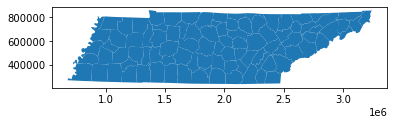

In [7]:
# Ask Michael, get this county-level base map shapefile instead
tn_county_map = gpd.read_file('../data/TN-county-basemap/tncounty.shp')
# See what the map looks like
tn_county_map.plot();

In [8]:
# Take a look at the base map dataframe
tn_county_map.head()

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ..."
1,77,Wayne,47181,2.050741e+10,666520.678598,"POLYGON ((1365052.057 391716.806, 1365746.554 ..."
2,78,Tipton,47167,1.319125e+10,865093.887634,"MULTIPOLYGON (((886814.330 400456.525, 886774...."
3,79,Hamilton,47065,1.604776e+10,652926.001078,"POLYGON ((2274954.438 239788.911, 2274090.610 ..."
4,80,Stewart,47161,1.375003e+10,490090.336180,"POLYGON ((1382472.783 743972.302, 1382445.171 ..."


In [9]:
# Check to make sure nothing is missing
tn_county_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    95 non-null     int64   
 1   NAME        95 non-null     object  
 2   KEY         95 non-null     object  
 3   SHAPE_AREA  95 non-null     float64 
 4   SHAPE_LEN   95 non-null     float64 
 5   geometry    95 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 4.6+ KB


In [10]:
# check the projection type
tn_county_map.crs

<Projected CRS: EPSG:2274>
Name: NAD83 / Tennessee (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - Tennessee
- bounds: (-90.31, 34.98, -81.65, 36.68)
Coordinate Operation:
- name: SPCS83 Tennessee zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [11]:
# change the projection type
tn_county_map = tn_county_map.to_crs('EPSG:4326')
print(tn_county_map.crs)
# Clean up some of the columns we don't need
tn_county_map = tn_county_map.drop(['OBJECTID', 'KEY', 'SHAPE_LEN'], axis = 1)
# Reformat column headers
tn_county_map.columns = ['county', 'shape_area', 'geometry']
# Set the county names to lower case
tn_county_map['county'] = tn_county_map['county'].str.lower()
# Make sure the base map dataset is good to go
tn_county_map.head(2)

EPSG:4326


,county,shape_area,geometry
0,chester,8.049024e+09,"POLYGON ((-88.78177 35.24759, -88.78185 35.247..."
1,wayne,2.050741e+10,"POLYGON ((-88.02474 35.39231, -88.02237 35.390..."


### Read in the deadly earthquakes since 1900 wikitable and turn it into a Geo DataFrame.

In [12]:
earthquakes = pd.read_csv('../data/earthquakes_wikitable.csv')
earthquakes.head()

,origin_utc,date_ymd,time,country,lat,long,depth_km,magnitude,magnitude_num,secondary_effects,pde_shaking_deaths,pde_total_deaths,utsu_total_deaths,em_dat_total_deaths,other_source_deaths,other_source_deaths_new,osd1,osd2,osd3,max_deaths
0,1900-05-11 17:23,1900-05-11,17:23,Japan,38.700,141.100,5.0,7.0 MJMA,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-07-12 06:25,1900-07-12,06:25,Turkey,40.300,43.100,NaN,5.9 Muk,5.9,NaN,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN,NaN,140.0
2,1900-10-29 09:11,1900-10-29,09:11,Venezuela,11.000,-66.000,0.0,7.7 Mw,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1901-02-15 00:00,1901-02-15,00:00,China,26.000,100.100,0.0,6.5 Ms,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1901-03-31 07:11,1901-03-31,07:11,Bulgaria,43.400,28.700,NaN,6.4 Muk,6.4,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0


In [13]:
# Check the data types
earthquakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   origin_utc               1340 non-null   object 
 1   date_ymd                 1340 non-null   object 
 2   time                     1332 non-null   object 
 3   country                  1340 non-null   object 
 4   lat                      1325 non-null   object 
 5   long                     1325 non-null   object 
 6   depth_km                 1249 non-null   float64
 7   magnitude                1339 non-null   object 
 8   magnitude_num            1338 non-null   float64
 9   secondary_effects        373 non-null    object 
 10  pde_shaking_deaths       738 non-null    float64
 11  pde_total_deaths         749 non-null    float64
 12  utsu_total_deaths        1027 non-null   float64
 13  em_dat_total_deaths      559 non-null    float64
 14  other_source_deaths     

In [14]:
# Set the origin_utc column to a datetime
earthquakes['origin_utc'] = pd.to_datetime(earthquakes['origin_utc'])
# Create 
earthquakes['magnitude_type'] = earthquakes['magnitude'].str.extract(r'.*?(\w+)$')
# Clean up the lat/long columns
earthquakes['latitude'] = earthquakes['lat'].str.replace('?','')
earthquakes['longitude'] = earthquakes['long'].str.replace('?','')
# Turn the lat/long into floats
earthquakes['latitude'] = pd.to_numeric(earthquakes['latitude'], errors = 'raise')
earthquakes['longitude'] = pd.to_numeric(earthquakes['longitude'], errors = 'raise')
# Remove excess columns
earthquakes = earthquakes.drop(['date_ymd', 'time', 'lat', 'long', 'magnitude', 'pde_shaking_deaths', 'pde_total_deaths', 'utsu_total_deaths', 'em_dat_total_deaths', 'other_source_deaths', 'other_source_deaths_new', 'osd1', 'osd2', 'osd3'], axis = 1)
# Reorder columns
earthquakes = earthquakes[['origin_utc', 'country', 'latitude', 'longitude', 'depth_km', 'magnitude_num', 'magnitude_type', 'secondary_effects', 'max_deaths']]
# Make sure the data types are correct
earthquakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   origin_utc         1340 non-null   datetime64[ns]
 1   country            1340 non-null   object        
 2   latitude           1324 non-null   float64       
 3   longitude          1324 non-null   float64       
 4   depth_km           1249 non-null   float64       
 5   magnitude_num      1338 non-null   float64       
 6   magnitude_type     1338 non-null   object        
 7   secondary_effects  373 non-null    object        
 8   max_deaths         1273 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 94.3+ KB


In [15]:
# Create a new column named 'geometry' which combines the latitude and longitude
earthquakes['geometry'] = earthquakes.apply(lambda x: Point((float(x.longitude),
                                                            float(x.latitude))),
                                           axis = 1)
earthquakes.head()

,origin_utc,country,latitude,longitude,depth_km,magnitude_num,magnitude_type,secondary_effects,max_deaths,geometry
0,1900-05-11 17:23:00,Japan,38.7,141.1,5.0,7.0,MJMA,NaN,NaN,POINT (141.1 38.7)
1,1900-07-12 06:25:00,Turkey,40.3,43.1,NaN,5.9,Muk,NaN,140.0,POINT (43.1 40.3)
2,1900-10-29 09:11:00,Venezuela,11.0,-66.0,0.0,7.7,Mw,NaN,NaN,POINT (-66 11)
3,1901-02-15 00:00:00,China,26.0,100.1,0.0,6.5,Ms,NaN,NaN,POINT (100.1 26)
4,1901-03-31 07:11:00,Bulgaria,43.4,28.7,NaN,6.4,Muk,NaN,4.0,POINT (28.7 43.4)


In [16]:
# Turn the Wikipedia Deadly Earthquakes since 1900 table into a Geo Data Frame
earthquakes_geo = gpd.GeoDataFrame(earthquakes,
                                   crs = tn_county_map.crs,
                                   geometry = earthquakes['geometry'])

The Wikipedia deadly earthquakes since 1900 table is now ready for a spatial join.

### Next, pull in the USGS data for earthquakes in TN and turn it into a Geo DataFrame.  

Use the coordinates in this [gist](https://gist.github.com/jakebathman/719e8416191ba14bb6e700fc2d5fccc5) to only get earthquakes from near TN.

In [17]:
# Set the query URL
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime=1900-01-01&endtime=2020-10-22&minlatitude=34.9884&maxlatitude=36.6871&minlongitude=-90.3131&maxlongitude=-81.6518'
# Assign the response to a variable
r = requests.get(url)

In [18]:
# Read in the text of the response into a dataframe called usgs
usgs = pd.read_csv(StringIO(r.text))
# See what gets returned
usgs.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2020-10-21T21:49:45.720Z,36.070500,-89.802333,6.84,2.14,md,46.0,40.0,0.06430,0.10,nm,nm60312762,2020-10-22T12:49:53.160Z,"2 km NNE of Cooter, Missouri",earthquake,0.17,0.49,0.092,31.0,reviewed,nm,nm
1,2020-10-21T20:28:42.930Z,36.525000,-89.569167,6.85,1.69,md,19.0,50.0,0.02596,0.03,nm,nm60312752,2020-10-22T14:45:56.660Z,"3 km E of Marston, Missouri",earthquake,0.34,0.63,0.167,12.0,reviewed,nm,nm
2,2020-10-21T04:55:51.350Z,36.545667,-89.649000,8.01,1.61,md,24.0,44.0,0.02245,0.04,nm,nm60312697,2020-10-21T13:04:57.100Z,"4 km NW of Marston, Missouri",earthquake,0.44,0.40,0.147,21.0,reviewed,nm,nm
3,2020-10-21T03:00:08.800Z,36.313667,-89.536167,9.50,1.23,md,17.0,65.0,0.02693,0.06,nm,nm60312692,2020-10-21T13:18:24.430Z,"7 km NW of Ridgely, Tennessee",earthquake,0.68,0.51,0.032,10.0,reviewed,nm,nm
4,2020-10-20T18:50:21.800Z,36.267500,-89.523333,8.84,2.33,md,46.0,33.0,0.01520,0.11,nm,nm60312672,2020-10-21T12:29:35.220Z,"3 km W of Ridgely, Tennessee",earthquake,0.15,0.30,0.142,34.0,reviewed,nm,nm


In [19]:
# Make sure all of the fields are the proper data types
usgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9163 entries, 0 to 9162
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             9163 non-null   object 
 1   latitude         9163 non-null   float64
 2   longitude        9163 non-null   float64
 3   depth            9150 non-null   float64
 4   mag              9160 non-null   float64
 5   magType          9152 non-null   object 
 6   nst              6155 non-null   float64
 7   gap              6153 non-null   float64
 8   dmin             5979 non-null   float64
 9   rms              6164 non-null   float64
 10  net              9163 non-null   object 
 11  id               9163 non-null   object 
 12  updated          9163 non-null   object 
 13  place            9163 non-null   object 
 14  type             9163 non-null   object 
 15  horizontalError  6214 non-null   float64
 16  depthError       6213 non-null   float64
 17  magError      

In [20]:
# Remove excess columns
usgs = usgs.drop(['nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'horizontalError', 'depthError', 'magError', 'magNst', 'status', 'status', 'locationSource', 'magSource'], axis = 1)
usgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9163 entries, 0 to 9162
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       9163 non-null   object 
 1   latitude   9163 non-null   float64
 2   longitude  9163 non-null   float64
 3   depth      9150 non-null   float64
 4   mag        9160 non-null   float64
 5   magType    9152 non-null   object 
 6   place      9163 non-null   object 
 7   type       9163 non-null   object 
dtypes: float64(4), object(4)
memory usage: 572.8+ KB


In [21]:
# Create a geometry column
usgs['geometry'] = usgs.apply(lambda x: Point((float(x.longitude),
                                            float(x.latitude))),
                              axis = 1)
# Make sure it worked
usgs.head()

,time,latitude,longitude,depth,mag,magType,place,type,geometry
0,2020-10-21T21:49:45.720Z,36.070500,-89.802333,6.84,2.14,md,"2 km NNE of Cooter, Missouri",earthquake,POINT (-89.8023333 36.0705)
1,2020-10-21T20:28:42.930Z,36.525000,-89.569167,6.85,1.69,md,"3 km E of Marston, Missouri",earthquake,POINT (-89.5691667 36.525)
2,2020-10-21T04:55:51.350Z,36.545667,-89.649000,8.01,1.61,md,"4 km NW of Marston, Missouri",earthquake,POINT (-89.649 36.5456667)
3,2020-10-21T03:00:08.800Z,36.313667,-89.536167,9.50,1.23,md,"7 km NW of Ridgely, Tennessee",earthquake,POINT (-89.5361667 36.3136667)
4,2020-10-20T18:50:21.800Z,36.267500,-89.523333,8.84,2.33,md,"3 km W of Ridgely, Tennessee",earthquake,POINT (-89.5233333 36.2675)


In [22]:
# Subset to earthquakes that have happened within TN only, based on the place name
# Not actually necessary if we're going to plot points based on lat/long
# usgs_tn = usgs[usgs['place'].str.contains('(Tennessee)')]
# usgs_tn.info()

In [23]:
# Turn the USGS dataframe into a Geo DataFrame
usgs_geo = gpd.GeoDataFrame(usgs,
                            crs = tn_county_map.crs,
                            geometry = usgs['geometry'])

The usgs dataframe is now ready for a spatial join.

### Read in the TN demographics data by county

In [24]:
tn_demo = pd.read_csv('../data/TN-county-demographics-2010.csv')
# Check the top of the tn_demo dataframe
tn_demo.head()

,County,Total Population,Children\n(under 18),People Living in Rural or Isolated settings,People of Color,Disabilities*,Senior Citizens
0,Anderson,"75,129",21.90%,34.66%,6.80%,18.60%,17.40%
1,Bedford,"45,058",26.80%,55.60%,16%,15.70%,12.90%
2,Benton,"16,489",20.50%,78.46%,3.90%,24.60%,19.90%
3,Bledsoe,"12,876",21.50%,100.00%,6.40%,30%,15.40%
4,Blount,"123,010",22.30%,32.63%,5.60%,14.80%,16.10%


In [25]:
# lower case the county to avoid merge errors
tn_demo['County'] = tn_demo['County'].str.lower()
# Rename columns
tn_demo.columns = ['county', 'total_pop', 'pct_children_under_18', 'pct_people_living_in_rural_areas', 'pct_people_of_color', 'pct_people_with_disabilities', 'pct_senior_citizens']
tn_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   county                            95 non-null     object
 1   total_pop                         95 non-null     object
 2   pct_children_under_18             95 non-null     object
 3   pct_people_living_in_rural_areas  95 non-null     object
 4   pct_people_of_color               95 non-null     object
 5   pct_people_with_disabilities      95 non-null     object
 6   pct_senior_citizens               95 non-null     object
dtypes: object(7)
memory usage: 5.3+ KB


In [26]:
# remove non-numeric characters from the columns
tn_demo[['pct_children_under_18', 'pct_people_living_in_rural_areas', 'pct_people_of_color', 'pct_people_with_disabilities', 'pct_senior_citizens']] = tn_demo[['pct_children_under_18', 'pct_people_living_in_rural_areas', 'pct_people_of_color', 'pct_people_with_disabilities', 'pct_senior_citizens']].apply(lambda x: x.str.replace('%',''))
tn_demo.total_pop = tn_demo.total_pop.str.replace(',','')
tn_demo

,county,total_pop,pct_children_under_18,pct_people_living_in_rural_areas,pct_people_of_color,pct_people_with_disabilities,pct_senior_citizens
0,anderson,75129,21.90,34.66,6.80,18.60,17.40
1,bedford,45058,26.80,55.60,16,15.70,12.90
2,benton,16489,20.50,78.46,3.90,24.60,19.90
3,bledsoe,12876,21.50,100.00,6.40,30,15.40
4,blount,123010,22.30,32.63,5.60,14.80,16.10
5,bradley,98963,23.00,32.97,8.60,18.10,14.10
6,campbell,40716,22.00,55.02,2.10,22.80,17.20
7,cannon,13801,22.50,81.13,3.10,18.40,16.10
8,carroll,28522,21.90,83.06,12.20,21.20,17.90
9,carter,57424,20.10,40.97,3.10,22.40,17.10


In [27]:
tn_demo[['total_pop', 'pct_children_under_18', 'pct_people_living_in_rural_areas', 'pct_people_of_color', 'pct_people_with_disabilities', 'pct_senior_citizens']] = tn_demo[['total_pop', 'pct_children_under_18', 'pct_people_living_in_rural_areas', 'pct_people_of_color', 'pct_people_with_disabilities', 'pct_senior_citizens']].apply(pd.to_numeric, errors = 'raise')
tn_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   county                            95 non-null     object 
 1   total_pop                         95 non-null     int64  
 2   pct_children_under_18             95 non-null     float64
 3   pct_people_living_in_rural_areas  95 non-null     float64
 4   pct_people_of_color               95 non-null     float64
 5   pct_people_with_disabilities      95 non-null     float64
 6   pct_senior_citizens               95 non-null     float64
dtypes: float64(5), int64(1), object(1)
memory usage: 5.3+ KB


The TN demographics dataframe is now ready for a non-spatial join.

### Read in and clean up the census housing units by county for TN data.

In [28]:
# Only read in the relevant lines of the csv
tn_housing = pd.read_csv('../data/us_census_tn_housing_units_by_county_2010-2019.csv')[2:99]

In [29]:
# Use the first row as the column headers
tn_housing.columns = tn_housing.iloc[0]
# Remove the excess lines from the dataframe
tn_housing = tn_housing[2:99]

In [30]:
# Reset the index
tn_housing = tn_housing.reset_index(drop = True)
tn_housing

2,NaN,Census,Estimates Base,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,".Anderson County, Tennessee","34,717","34,700","34,709","34,774","34,763","34,758","34,783","34,872","34,913","34,962","35,029","35,143"
1,".Bedford County, Tennessee","18,360","18,360","18,403","18,503","18,537","18,580","18,631","18,775","18,913","19,082","19,300","19,531"
2,".Benton County, Tennessee","8,975","8,975","8,977","8,984","9,040","9,049","9,061","9,069","9,083","9,108","9,147","9,172"
3,".Bledsoe County, Tennessee","5,718","5,720","5,724","5,708","5,717","5,726","5,735","5,743","5,755","5,769","5,785","5,796"
4,".Blount County, Tennessee","55,266","55,303","55,342","55,474","55,594","55,856","56,413","56,689","57,026","57,498","58,390","58,942"
5,".Bradley County, Tennessee","41,395","41,378","41,427","41,740","41,950","42,177","42,428","42,903","43,412","43,719","44,118","44,532"
6,".Campbell County, Tennessee","19,966","19,970","20,011","20,116","20,222","20,326","20,454","20,583","20,750","20,937","21,157","21,394"
7,".Cannon County, Tennessee","6,037","6,043","6,046","6,055","6,066","6,080","6,094","6,108","6,122","6,142","6,164","6,164"
8,".Carroll County, Tennessee","13,184","13,167","13,189","13,238","13,241","13,240","13,242","13,243","13,249","13,259","13,271","13,273"
9,".Carter County, Tennessee","27,746","27,730","27,747","27,849","27,887","27,908","27,970","27,983","28,059","28,178","28,263","28,350"


In [31]:
# Drop the excess columns
tn_housing = tn_housing.drop(['Census', 'Estimates Base', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'], axis = 1)
# Rename the columns
tn_housing.columns = ['county', 'total_housing_units_2019']
# Clean up and standardize the county names
tn_housing['county'] = tn_housing['county'].str.extract(r'\.(.*) County, Tennessee')
tn_housing['county'] = tn_housing['county'].str.lower()
tn_housing['total_housing_units_2019'] = tn_housing['total_housing_units_2019'].str.replace(',','')
tn_housing['total_housing_units_2019'] = pd.to_numeric(tn_housing['total_housing_units_2019'], errors = 'raise')

In [32]:
tn_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   county                    95 non-null     object
 1   total_housing_units_2019  95 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


The TN housing units dataset is now ready to join.

### Read in the ACS dataframe

In [33]:
acs = pd.read_csv('../data/acs_5yr_subset_clean.csv')
acs.head()

,geo_id,county_full,county,population_est,pct_insured,race_afam,race_asam,race_latn,race_natam,race_paci,race_white,race_othr,race_multi,disability_y,disability_n,edu_lessHS,edu_HSgrad,edu_assoc,edu_min_bac,employed_est,unemployed_est,tot_w_poverty_lvl_data,tot_poverty_less100,tot_poverty_101_138,tot_poverty_138_399,tot_poverty_400_up
0,0500000US47001,"Anderson County, Tennessee",anderson,74862,90.8,2365,1018,2094,377,29,66911,637,2021,14157,60705,6828,17453,15622,12480,30244,1969,74292,12022,5901,33240,23129
1,0500000US47003,"Bedford County, Tennessee",bedford,47184,88.7,3384,79,5682,27,29,36541,2404,1495,7526,39658,5814,12314,7346,4999,19883,940,46923,7420,4105,24435,10963
2,0500000US47005,"Benton County, Tennessee",benton,15960,90.3,507,34,274,69,0,14835,0,285,4297,11663,2161,5447,2519,1404,5185,443,15922,3403,2114,7145,3260
3,0500000US47007,"Bledsoe County, Tennessee",bledsoe,13436,87.0,347,8,252,223,0,12220,23,371,3603,9833,2489,3692,2362,1390,5367,527,13391,2721,1342,6438,2890
4,0500000US47009,"Blount County, Tennessee",blount,127292,91.2,3328,993,4145,369,127,116154,259,2481,18304,108988,9548,30868,26997,21624,54149,2857,126101,14808,8975,59213,43105


In [34]:
acs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   geo_id                  95 non-null     object 
 1   county_full             95 non-null     object 
 2   county                  95 non-null     object 
 3   population_est          95 non-null     int64  
 4   pct_insured             95 non-null     float64
 5   race_afam               95 non-null     int64  
 6   race_asam               95 non-null     int64  
 7   race_latn               95 non-null     int64  
 8   race_natam              95 non-null     int64  
 9   race_paci               95 non-null     int64  
 10  race_white              95 non-null     int64  
 11  race_othr               95 non-null     int64  
 12  race_multi              95 non-null     int64  
 13  disability_y            95 non-null     int64  
 14  disability_n            95 non-null     int6

The ACS data has already been cleaned and is ready for a non-spatial join.

### Read in the CDC Social Vulnerability Index dataframe

From [here](https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html)

In [35]:
# Only read in the Social Vulnerability Index scores for the counties in TN
svi = pd.read_csv('../data/TN-vulnerability-scores.csv', usecols=['COUNTY','AREA_SQMI','RPL_THEME1','RPL_THEME2','RPL_THEME3','RPL_THEME4','RPL_THEMES'])
svi.head()

,COUNTY,AREA_SQMI,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES
0,Moore,129.222493,0.0638,0.0532,0.1170,0.0213,0.0000
1,Williamson,582.866127,0.0000,0.0213,0.7447,0.0000,0.0106
2,Smith,314.294959,0.1596,0.4362,0.1383,0.0532,0.0213
3,Wilson,571.091033,0.0106,0.1064,0.7766,0.0426,0.0319
4,Fayette,704.774920,0.1702,0.0745,0.6383,0.0106,0.0426


In [36]:
svi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   COUNTY      95 non-null     object 
 1   AREA_SQMI   95 non-null     float64
 2   RPL_THEME1  95 non-null     float64
 3   RPL_THEME2  95 non-null     float64
 4   RPL_THEME3  95 non-null     float64
 5   RPL_THEME4  95 non-null     float64
 6   RPL_THEMES  95 non-null     float64
dtypes: float64(6), object(1)
memory usage: 5.3+ KB


In [37]:
# rename the columns
svi.columns = ['county', 'area_m2', 'socioeconomic', 'household_comp_and_disability', 'minority_status_and_language', 'housing_type_and_transportation', 'total_vulnerability']
svi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   county                           95 non-null     object 
 1   area_m2                          95 non-null     float64
 2   socioeconomic                    95 non-null     float64
 3   household_comp_and_disability    95 non-null     float64
 4   minority_status_and_language     95 non-null     float64
 5   housing_type_and_transportation  95 non-null     float64
 6   total_vulnerability              95 non-null     float64
dtypes: float64(6), object(1)
memory usage: 5.3+ KB


In [38]:
# convert the county to lowercase to facilitate joins
svi['county'] = svi['county'].str.lower()

In [39]:
# sort the dataset by the county, then reset the index
svi = svi.sort_values('county').reset_index(drop=True)
svi

,county,area_m2,socioeconomic,household_comp_and_disability,minority_status_and_language,housing_type_and_transportation,total_vulnerability
0,anderson,337.203175,0.2128,0.6277,0.6596,0.6489,0.4043
1,bedford,473.638959,0.3511,0.6915,0.9681,0.5319,0.6809
2,benton,394.306039,0.8085,0.7766,0.2553,0.6277,0.7766
3,bledsoe,406.424786,0.8723,0.1809,0.8085,0.9681,0.9574
4,blount,558.816658,0.0426,0.0426,0.5426,0.1702,0.0745
5,bradley,328.761662,0.3298,0.3936,0.8404,0.8830,0.5638
6,campbell,480.162536,0.8404,0.9255,0.0213,0.6596,0.7660
7,cannon,265.635253,0.2766,0.1489,0.1702,0.3085,0.1064
8,carroll,597.657317,0.6170,0.8298,0.4043,0.9149,0.8191
9,carter,341.258169,0.6489,0.6489,0.1489,0.7447,0.5319


The svi dataset is ready to join.

### Merge the non-spatial dataframes together  

Merge on the county level to build the framework for mapping the data.

In [40]:
# Join the demographics and housing data into one dataframe
tn_housing_demo = tn_demo.merge(tn_housing, how = 'outer', on = 'county')
tn_housing_demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   county                            95 non-null     object 
 1   total_pop                         95 non-null     int64  
 2   pct_children_under_18             95 non-null     float64
 3   pct_people_living_in_rural_areas  95 non-null     float64
 4   pct_people_of_color               95 non-null     float64
 5   pct_people_with_disabilities      95 non-null     float64
 6   pct_senior_citizens               95 non-null     float64
 7   total_housing_units_2019          95 non-null     int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 6.7+ KB


In [41]:
tn_housing_demo_acs = tn_housing_demo.merge(acs, how = 'outer', on = 'county')
tn_housing_demo_acs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   county                            95 non-null     object 
 1   total_pop                         95 non-null     int64  
 2   pct_children_under_18             95 non-null     float64
 3   pct_people_living_in_rural_areas  95 non-null     float64
 4   pct_people_of_color               95 non-null     float64
 5   pct_people_with_disabilities      95 non-null     float64
 6   pct_senior_citizens               95 non-null     float64
 7   total_housing_units_2019          95 non-null     int64  
 8   geo_id                            95 non-null     object 
 9   county_full                       95 non-null     object 
 10  population_est                    95 non-null     int64  
 11  pct_insured                       95 non-null     float64
 12  race_afam 

In [42]:
tn_housing_demo_acs_svi = tn_housing_demo_acs.merge(svi, how = 'outer', on = 'county')
tn_housing_demo_acs_svi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 39 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   county                            95 non-null     object 
 1   total_pop                         95 non-null     int64  
 2   pct_children_under_18             95 non-null     float64
 3   pct_people_living_in_rural_areas  95 non-null     float64
 4   pct_people_of_color               95 non-null     float64
 5   pct_people_with_disabilities      95 non-null     float64
 6   pct_senior_citizens               95 non-null     float64
 7   total_housing_units_2019          95 non-null     int64  
 8   geo_id                            95 non-null     object 
 9   county_full                       95 non-null     object 
 10  population_est                    95 non-null     int64  
 11  pct_insured                       95 non-null     float64
 12  race_afam 

In [43]:
# Rename the final dataframe for ease of use
tn_data = tn_housing_demo_acs_svi

### Merge the non-spatial aggregate dataframe to the base map

In [44]:
# Join in the demographic data to the TN base map
tn_data_map = tn_county_map.merge(tn_data, on = 'county')
# Check to make sure it is a full join
tn_data_map

,county,shape_area,geometry,total_pop,pct_children_under_18,pct_people_living_in_rural_areas,pct_people_of_color,pct_people_with_disabilities,pct_senior_citizens,total_housing_units_2019,geo_id,county_full,population_est,pct_insured,race_afam,race_asam,race_latn,race_natam,race_paci,race_white,race_othr,race_multi,disability_y,disability_n,edu_lessHS,edu_HSgrad,edu_assoc,edu_min_bac,employed_est,unemployed_est,tot_w_poverty_lvl_data,tot_poverty_less100,tot_poverty_101_138,tot_poverty_138_399,tot_poverty_400_up,area_m2,socioeconomic,household_comp_and_disability,minority_status_and_language,housing_type_and_transportation,total_vulnerability
0,chester,8.049024e+09,"POLYGON ((-88.78177 35.24759, -88.78185 35.247...",17131,23.3,65.24,10.6,15.6,14.6,7170,0500000US47023,"Chester County, Tennessee",16949,88.0,1745,86,170,7,0,14541,141,402,2373,14576,1449,4317,3049,1785,6366,498,15917,2951,874,8583,3509,285.736117,0.6596,0.4255,0.5106,0.3298,0.5213
1,wayne,2.050741e+10,"POLYGON ((-88.02474 35.39231, -88.02237 35.390...",17021,19.6,100.00,8.5,20.1,15.9,7366,0500000US47181,"Wayne County, Tennessee",14606,88.8,378,64,284,43,0,13784,15,43,3030,11576,1908,4460,2561,1291,5308,382,14553,2853,1341,7393,2966,734.108826,0.7979,0.1915,0.2979,1.0000,0.8298
2,tipton,1.319125e+10,"MULTIPOLYGON (((-89.62931 35.37836, -89.62944 ...",61081,27.2,55.13,20.7,15.5,11.1,24104,0500000US47167,"Tipton County, Tennessee",60558,90.6,10832,469,1594,230,94,46116,255,1326,9672,50886,4975,15101,12280,6634,25641,1907,60391,8432,4299,27230,20430,458.403998,0.2234,0.6064,0.6809,0.0638,0.1702
3,hamilton,1.604776e+10,"POLYGON ((-84.97698 34.98767, -84.97986 34.987...",336463,21.6,10.02,23.7,14.5,14.7,165494,0500000US47065,"Hamilton County, Tennessee",353438,91.0,68528,7218,19384,583,147,251820,3164,7310,49895,303543,25380,66405,73395,76178,157068,8872,346362,47360,25001,147921,126080,542.339868,0.0745,0.0106,0.9362,0.7021,0.2021
4,stewart,1.375003e+10,"POLYGON ((-87.99034 36.36078, -87.99044 36.360...",13324,22.9,100.00,5.0,20.4,16.7,6896,0500000US47161,"Stewart County, Tennessee",13087,90.0,150,99,359,61,50,12049,65,359,2730,10357,1321,3919,2599,1332,4855,384,13024,2159,946,6563,3356,459.775870,0.4043,0.5319,0.2021,0.0319,0.1170
5,robertson,1.328462e+10,"POLYGON ((-87.12044 36.45546, -87.12026 36.456...",66283,25.7,53.24,11.5,12.6,11.8,28034,0500000US47147,"Robertson County, Tennessee",68433,91.0,4618,378,4653,218,48,57409,1189,1611,10037,58396,5528,17710,13516,8538,31127,1804,68281,7923,4995,31185,24178,476.314061,0.1383,0.4149,0.9043,0.1489,0.2340
6,sumner,1.514543e+10,"POLYGON ((-86.75480 36.40545, -86.75373 36.405...",160645,25.3,27.88,9.7,11.5,12.6,75354,0500000US47165,"Sumner County, Tennessee",177908,91.3,12504,2282,8363,586,217,150848,2394,3834,24836,153072,11798,37006,37932,32252,82320,3174,177361,16833,9979,80275,70274,529.403390,0.0213,0.2128,0.7979,0.0745,0.0638
7,fentress,1.391048e+10,"POLYGON ((-85.11963 36.14466, -85.11958 36.144...",17959,23.1,100.00,1.6,24.6,17.0,9063,0500000US47049,"Fentress County, Tennessee",17818,90.3,0,108,269,32,0,17244,53,165,4268,13550,2453,5523,2697,1713,6042,450,17680,3855,2471,8176,3178,498.611086,0.8617,0.8191,0.0213,0.4149,0.6383
8,overton,1.212162e+10,"POLYGON ((-85.32358 36.20400, -85.32359 36.204...",22083,23.2,84.22,1.9,18.7,16.8,10392,0500000US47133,"Overton County, Tennessee",21723,91.3,104,104,298,0,75,20934,7,206,3436,18287,3042,6714,3150,2007,8280,328,21682,3687,2649,11687,3659,433.485027,0.5319,0.3085,0.0957,0.3936,0.2766
9,jackson,8.907469e+09,"POLYGON ((-85.78015 36.23801, -85.78045 36.238...",11638,20.4,100.00,1.8,22.8,17.7,5933,0500000US47087,"Jackson County, Tennessee",11419,89.7,57,8,228,0,0,10935,169,213,2686,8733,1730,3946,1868,747,4007,372,11400,2241,1210,5924,2025,308.637955,0.8830,0.4468,0.0426,0.6809,0.6064


In [45]:
# Check to make sure nothing got dropped along the way
tn_data_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   county                            95 non-null     object  
 1   shape_area                        95 non-null     float64 
 2   geometry                          95 non-null     geometry
 3   total_pop                         95 non-null     int64   
 4   pct_children_under_18             95 non-null     float64 
 5   pct_people_living_in_rural_areas  95 non-null     float64 
 6   pct_people_of_color               95 non-null     float64 
 7   pct_people_with_disabilities      95 non-null     float64 
 8   pct_senior_citizens               95 non-null     float64 
 9   total_housing_units_2019          95 non-null     int64   
 10  geo_id                            95 non-null     object  
 11  county_full                       95 non-null     ob

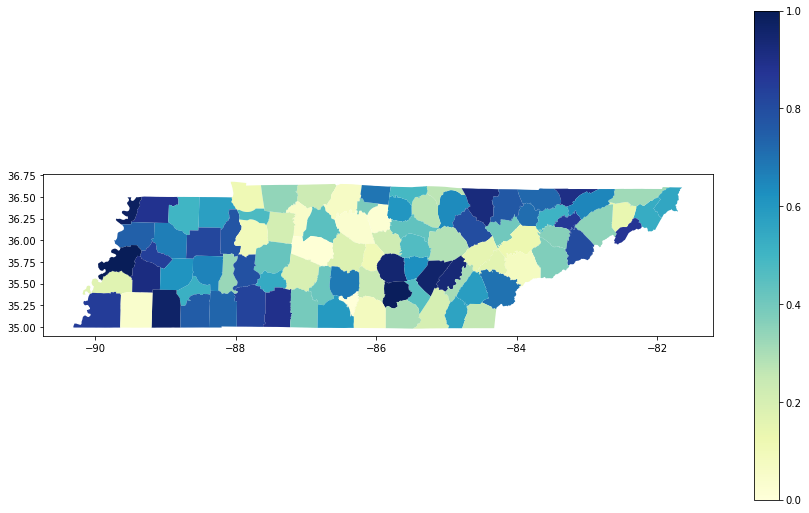

In [46]:
# Start exploring the data visually
ax = tn_data_map.plot(column='total_vulnerability', cmap =    
                                'YlGnBu', figsize=(15,9),   
                                 legend = True)

In [65]:
# Build a widget
@widgets.interact(
    column = ['total_pop', 'pct_children_under_18', 'pct_people_living_in_rural_areas', 'pct_people_of_color', 'pct_people_with_disabilities', 'pct_senior_citizens', 'total_housing_units_2019', 'geo_id', 'county_full', 'population_est', 'pct_insured', 'race_afam', 'race_asam', 'race_latn', 'race_natam', 'race_paci', 'race_white', 'race_othr', 'race_multi', 'disability_y', 'disability_n', 'edu_lessHS', 'edu_HSgrad', 'edu_assoc', 'edu_min_bac', 'employed_est', 'unemployed_est', 'tot_w_poverty_lvl_data', 'tot_poverty_less100', 'tot_poverty_101_138', 'tot_poverty_138_399', 'tot_poverty_400_up', 'area_m2', 'socioeconomic', 'household_comp_and_disability', 'minority_status_and_language', 'housing_type_and_transportation', 'total_vulnerability'])

def throw_some_shade(column):
    """
    Change the choropleth based on the column value
    """
    ax = tn_data_map.plot(column=column, cmap =    
                                'YlGnBu', figsize=(30,9),   
                                 legend = True)
    plt.axis('off')

#widgets.interact(throw_some_shade, col=['total_pop', 'pct_children_under_18', 'pct_people_living_in_rural_areas']);

interactive(children=(Dropdown(description='column', options=('total_pop', 'pct_children_under_18', 'pct_peopl…

In [64]:
tn_data_map.columns

Index(['county', 'shape_area', 'geometry', 'total_pop', 'pct_children_under_18', 'pct_people_living_in_rural_areas', 'pct_people_of_color', 'pct_people_with_disabilities', 'pct_senior_citizens', 'total_housing_units_2019', 'geo_id', 'county_full', 'population_est', 'pct_insured', 'race_afam', 'race_asam', 'race_latn', 'race_natam', 'race_paci', 'race_white', 'race_othr', 'race_multi', 'disability_y', 'disability_n', 'edu_lessHS', 'edu_HSgrad', 'edu_assoc', 'edu_min_bac', 'employed_est', 'unemployed_est', 'tot_w_poverty_lvl_data', 'tot_poverty_less100', 'tot_poverty_101_138', 'tot_poverty_138_399', 'tot_poverty_400_up', 'area_m2', 'socioeconomic', 'household_comp_and_disability', 'minority_status_and_language', 'housing_type_and_transportation', 'total_vulnerability'], dtype='object')

### Add of the USGS earthquakes since 1900 to the data-enriched TN base map

In [48]:
# Join the USGS data to the TN basemap
tn_earthquakes = gpd.sjoin(usgs_geo, tn_data_map, op = 'within')
tn_earthquakes

,time,latitude,longitude,depth,mag,magType,place,type,geometry,index_right,county,shape_area,total_pop,pct_children_under_18,pct_people_living_in_rural_areas,pct_people_of_color,pct_people_with_disabilities,pct_senior_citizens,total_housing_units_2019,geo_id,county_full,population_est,pct_insured,race_afam,race_asam,race_latn,race_natam,race_paci,race_white,race_othr,race_multi,disability_y,disability_n,edu_lessHS,edu_HSgrad,edu_assoc,edu_min_bac,employed_est,unemployed_est,tot_w_poverty_lvl_data,tot_poverty_less100,tot_poverty_101_138,tot_poverty_138_399,tot_poverty_400_up,area_m2,socioeconomic,household_comp_and_disability,minority_status_and_language,housing_type_and_transportation,total_vulnerability
3,2020-10-21T03:00:08.800Z,36.313667,-89.536167,9.50,1.23,md,"7 km NW of Ridgely, Tennessee",earthquake,POINT (-89.53617 36.31367),24,lake,5.402735e+09,7832,16.7,100.00,29.8,25.6,13.7,2596,0500000US47095,"Lake County, Tennessee",4831,89.8,981,10,131,11,0,3614,35,94,1114,3717,752,1275,716,431,1763,208,4714,1268,471,1815,1160,165.784957,1.0000,0.5000,0.4787,0.9574,0.9787
4,2020-10-20T18:50:21.800Z,36.267500,-89.523333,8.84,2.33,md,"3 km W of Ridgely, Tennessee",earthquake,POINT (-89.52333 36.26750),24,lake,5.402735e+09,7832,16.7,100.00,29.8,25.6,13.7,2596,0500000US47095,"Lake County, Tennessee",4831,89.8,981,10,131,11,0,3614,35,94,1114,3717,752,1275,716,431,1763,208,4714,1268,471,1815,1160,165.784957,1.0000,0.5000,0.4787,0.9574,0.9787
6,2020-10-19T20:31:16.660Z,36.419667,-89.499000,7.78,1.30,md,"5 km NNW of Tiptonville, Tennessee",earthquake,POINT (-89.49900 36.41967),24,lake,5.402735e+09,7832,16.7,100.00,29.8,25.6,13.7,2596,0500000US47095,"Lake County, Tennessee",4831,89.8,981,10,131,11,0,3614,35,94,1114,3717,752,1275,716,431,1763,208,4714,1268,471,1815,1160,165.784957,1.0000,0.5000,0.4787,0.9574,0.9787
16,2020-10-12T11:33:20.900Z,36.345000,-89.516667,5.33,1.33,md,"5 km SW of Tiptonville, Tennessee",earthquake,POINT (-89.51667 36.34500),24,lake,5.402735e+09,7832,16.7,100.00,29.8,25.6,13.7,2596,0500000US47095,"Lake County, Tennessee",4831,89.8,981,10,131,11,0,3614,35,94,1114,3717,752,1275,716,431,1763,208,4714,1268,471,1815,1160,165.784957,1.0000,0.5000,0.4787,0.9574,0.9787
17,2020-10-12T05:37:13.920Z,36.297167,-89.535667,10.26,1.45,md,"5 km NW of Ridgely, Tennessee",earthquake,POINT (-89.53567 36.29717),24,lake,5.402735e+09,7832,16.7,100.00,29.8,25.6,13.7,2596,0500000US47095,"Lake County, Tennessee",4831,89.8,981,10,131,11,0,3614,35,94,1114,3717,752,1275,716,431,1763,208,4714,1268,471,1815,1160,165.784957,1.0000,0.5000,0.4787,0.9574,0.9787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7442,1984-06-17T17:05:47.900Z,35.390000,-88.780000,5.00,2.00,md,"13km WSW of Henderson, Tennessee",earthquake,POINT (-88.78000 35.39000),0,chester,8.049024e+09,17131,23.3,65.24,10.6,15.6,14.6,7170,0500000US47023,"Chester County, Tennessee",16949,88.0,1745,86,170,7,0,14541,141,402,2373,14576,1449,4317,3049,1785,6366,498,15917,2951,874,8583,3509,285.736117,0.6596,0.4255,0.5106,0.3298,0.5213
7491,1984-01-17T02:36:13.540Z,35.435000,-88.087000,8.10,2.20,md,"9km WNW of Clifton, Tennessee",earthquake,POINT (-88.08700 35.43500),52,decatur,9.615720e+09,11757,21.5,100.00,4.8,22.1,20.7,6931,0500000US47039,"Decatur County, Tennessee",11443,91.6,396,47,198,0,0,10524,22,300,2188,9255,1226,3493,2220,1028,4094,359,11443,2228,1216,5471,2528,333.877450,0.6064,0.5851,0.1915,0.1383,0.3298
8614,1978-02-15T18:06:58.100Z,35.710000,-88.070000,5.00,2.20,mlg,"8km NE of Parsons, Tennessee",earthquake,POINT (-88.07000 35.71000),52,decatur,9.615720e+09,11757,21.5,100.00,4.8,22.1,20.7,6931,0500000US47039,"Decatur County, Tennessee",11443,91.6,396,47,198,0,0,10524,22,300,2188,9255,1226,3493,2220,1028,4094,359,11443,2228,1216,5471,2528,333.877450,0.6064,0.5851,0.1915,0.1383,0.3298
7538,1983-08-27T01:25:50.800Z,35.065000,-89

In [49]:
# Since 1900, how many earthquakes per county?
tn_earthquakes['county'].value_counts()

lake          2118
dyer           644
obion          391
monroe         210
blount         135
loudon         100
mcminn          91
knox            59
lauderdale      40
rhea            38
bradley         36
roane           35
sevier          30
grainger        29
meigs           28
hamilton        28
polk            24
tipton          22
bledsoe         18
claiborne       17
campbell        14
gibson          14
jefferson       14
marion          11
union           11
greene          10
morgan           7
lawrence         6
hamblen          5
sequatchie       5
hardin           4
anderson         4
grundy           4
shelby           4
washington       3
cumberland       3
sullivan         3
johnson          3
hawkins          3
perry            3
crockett         3
henderson        3
weakley          3
giles            3
van buren        2
wayne            2
hancock          2
fayette          2
cocke            2
unicoi           2
franklin         2
carroll          2
scott       

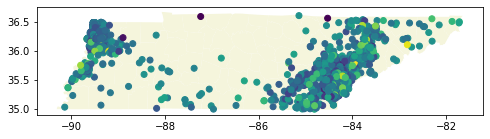

In [50]:
# map the earthquakes, color-coded by magnitute
ax = tn_county_map.plot(figsize = (8, 10), color = 'beige')
tn_earthquakes.plot( ax = ax, column = 'mag');
plt.show();

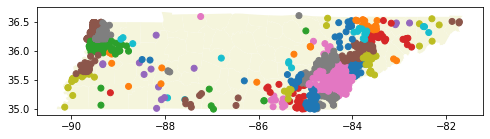

In [51]:
# map the earthquakes, color-coded by county
ax = tn_county_map.plot(figsize = (8, 10), color = 'beige')
tn_earthquakes.plot( ax = ax, column = 'county');
plt.show();

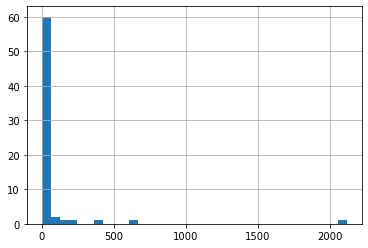

In [52]:
tn_earthquakes['county'].value_counts().hist(bins = 35);

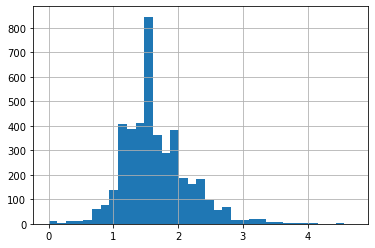

In [53]:
tn_earthquakes['mag'].hist(bins = 35);

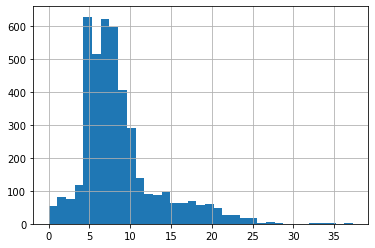

In [54]:
tn_earthquakes['depth'].hist(bins = 35);